In [33]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# settings
pio.templates.default = "simple_white"

In [2]:
data = pd.read_parquet('data_cleaned.parquet')
data

,Datum,Standort,Parameter,Wert,Lat,Lon
0,1983-01-01 00:00:00,Zch_Stampfenbachstrasse,CO in mg/m3,4.09,47.38239,8.54174
1,1983-01-01 00:00:00,Zch_Stampfenbachstrasse,NO2 in µg/m3,64.25,47.38239,8.54174
2,1983-01-01 00:00:00,Zch_Stampfenbachstrasse,NO in µg/m3,211.32,47.38239,8.54174
3,1983-01-01 00:00:00,Zch_Stampfenbachstrasse,NOx in ppb,203.02,47.38239,8.54174
4,1983-01-01 00:00:00,Zch_Stampfenbachstrasse,SO2 in µg/m3,126.44,47.38239,8.54174
...,...,...,...,...,...,...
210217,2021-12-31 23:00:00,Zch_Stampfenbachstrasse,SO2 in µg/m3,10.55,47.38239,8.54174
210216,2021-12-31 23:00:00,Zch_Stampfenbachstrasse,CO in mg/m3,0.54,47.38239,8.54174
210238,2021-12-31 23:00:00,Zch_Rosengartenstrasse,PM10 in µg/m3,61.90,47.39510,8.52592
210226,2021-12-31 23:00:00,Zch_Schimmelstrasse,NO2 in µg/m3,38.32,47.37027,8.52489


## 3D Plots

In [3]:

data_v1 = data[data["Parameter"] == "CO in mg/m3"][["Datum", "Parameter", "Wert"]].copy()
data_v1.loc[:, "Year"] = data_v1["Datum"].dt.year
data_v1.loc[:, "Month"] = data_v1["Datum"].dt.month

data_v1 = data_v1.groupby(["Year", "Month", "Parameter"]).mean().reset_index()
data_v1["Time"] = pd.to_datetime(data_v1[["Year", "Month"]].assign(DAY=1))
data_v1 = data_v1.drop(["Year", "Month", "Datum"], axis=1)

start_time = data_v1['Time'].min()
data_v1['time_years'] = data_v1['Time'].apply(lambda x: (x - start_time).days / 365.25)

# Map 'time_years' to a value between 0 and 2*pi for each year
data_v1['time_normalized'] = data_v1['time_years'].apply(lambda x: 2 * np.pi * (x % 1))  # x%1 gives the fractional part

# Convert Time and Wert to 3D coordinates
data_v1['x'] = data_v1['Wert'] * np.cos(data_v1['time_normalized'])
data_v1['y'] = data_v1['Wert'] * np.sin(data_v1['time_normalized'])
data_v1['z'] = data_v1['time_years']

# Get the min and max values for the z axis
z_min = data_v1['Time'].dt.year.min()
z_max = data_v1['Time'].dt.year.max()
z_ticktext = np.linspace(z_min, z_max, 20, dtype=int)
z_tickvals = np.linspace(0, z_max - z_min, 20, dtype=int)

fig = go.Figure(data=[go.Scatter3d(
    x=data_v1['x'],
    y=data_v1['y'],
    z=data_v1['z'],
    mode='lines',
    line=dict(
        color=data_v1['Wert'],
        colorscale='Viridis',
        width=4
    ),
    name='',
    hovertemplate='%{text}',
    text="Date:<br>" + data_v1['Time'].dt.strftime('%Y-%m') + f'<br>-----<br>Mean CO in mg/m3:<br>' + data_v1['Wert'].round(4).astype(str)
)])

fig.update_layout(
    scene=dict(
        xaxis_title="",
        yaxis_title="",
        zaxis_title='Year',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.8, y=1, z=0.5)
        ),
        aspectratio=dict(x=1, y=1, z=1.2),
        xaxis=dict(showgrid=False, ticktext=[], tickvals=[]),
        yaxis=dict(showgrid=False, ticktext=[], tickvals=[]),
        zaxis=dict(showgrid=False, ticktext=z_ticktext, tickvals=z_tickvals)
    ),
    scene_bgcolor='rgba(0,0,0,0)',
    template="simple_white",
    margin=dict(r=0, l=0, b=0, t=0),
    title={
        'text': f"Durchschnittlicher CO Wert (in mg/m3) in der Stadt Zürich über die Jahre",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    showlegend=False,
)

highest_value_index = data_v1['Wert'].idxmax()
x_line_1 = data_v1.loc[highest_value_index, 'x']
y_line_1 = data_v1.loc[highest_value_index, 'y']
z_line_1 = data_v1.loc[highest_value_index, 'z']

# Höchster Wert
line = go.Scatter3d(
    x=[x_line_1, x_line_1],
    y=[1 + y_line_1, y_line_1],
    z=[10 + z_line_1, z_line_1],
    mode='lines',
    line=dict(
        color='black',
        width=2
    ),
    hoverinfo="none",
    showlegend=False
)

fig.add_trace(line)

annotations = go.Scatter3d(
    x=[x_line_1],
    y=[1 + y_line_1],
    z=[10 + z_line_1],
    mode='text',
    text=["Höchster gemessene CO Wert"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='black', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# Neuste Messung
x_line_2 = data_v1[data_v1['Time'] == '2021-12-01']['x'].values[0]
y_line_2 = data_v1[data_v1['Time'] == '2021-12-01']['y'].values[0]
z_line_2 = data_v1[data_v1['Time'] == '2021-12-01']['z'].values[0]

line = go.Scatter3d(
    x=[-2 + x_line_2, x_line_2],
    y=[2 + y_line_2, y_line_2],
    z=[-2 + z_line_2, z_line_2],
    mode='lines',
    line=dict(
        color='black',
        width=2
    ),
    hoverinfo="none",
    showlegend=False
)

fig.add_trace(line)

annotations = go.Scatter3d(
    x=[-2 + x_line_2],
    y=[2 + y_line_2],
    z=[-5 + z_line_2],
    mode='text',
    text=["Neuste Messung (2021-12)"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='black', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# 2016: 1% aller Neuzulassungen in der Schweiz waren Elektroautos
x_line_3 = data_v1[data_v1['Time'] == '2016-01-01']['x'].values[0]
y_line_3 = data_v1[data_v1['Time'] == '2016-01-01']['y'].values[0]
z_line_3 = data_v1[data_v1['Time'] == '2016-01-01']['z'].values[0]

line = go.Scatter3d(
    x=[-2 + x_line_3, x_line_3],
    y=[2 + y_line_3, y_line_3],
    z=[-2 + z_line_3, z_line_3],
    mode='lines',
    line=dict(
        color='black',
        width=2
    ),
    hoverinfo="none",
    showlegend=False
)

fig.add_trace(line)

annotations = go.Scatter3d(
    x=[-2 + x_line_3],
    y=[2 + y_line_3],
    z=[-6 + z_line_3],
    mode='text',
    text=["1% aller Neuzulassungen<br> in CH waren Elektroautos"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='black', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# 2021: 13% aller Neuzulassungen in der Schweiz waren Elektroautos
x_line_4 = data_v1[data_v1['Time'] == '2021-01-01']['x'].values[0]
y_line_4 = data_v1[data_v1['Time'] == '2021-01-01']['y'].values[0]
z_line_4 = data_v1[data_v1['Time'] == '2021-01-01']['z'].values[0]

line = go.Scatter3d(
    x=[2 + x_line_4, x_line_4],
    y=[-2 + y_line_4, y_line_4],
    z=[-2 + z_line_4, z_line_4],
    mode='lines',
    line=dict(
        color='black',
        width=2
    ),
    hoverinfo="none",
    showlegend=False
)

fig.add_trace(line)

annotations = go.Scatter3d(
    x=[2 + x_line_4],
    y=[-2 + y_line_4],
    z=[-6 + z_line_4],
    mode='text',
    text=["13% aller Neuzulassungen<br> in CH waren Elektroautos"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='black', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# Katalysatorpflicht ab Januar 1986
x_line_5 = data_v1[data_v1['Time'] == '1986-01-01']['x'].values[0]
y_line_5 = data_v1[data_v1['Time'] == '1986-01-01']['y'].values[0]
z_line_5 = data_v1[data_v1['Time'] == '1986-01-01']['z'].values[0]

line = go.Scatter3d(
    x=[0 + x_line_5, x_line_5],
    y=[4 + y_line_5, y_line_5],
    z=[8 + z_line_5, z_line_5],
    mode='lines',
    line=dict(
        color='black',
        width=2
    ),
    hoverinfo="none",
    showlegend=False
)

fig.add_trace(line)

annotations = go.Scatter3d(
    x=[0 + x_line_5],
    y=[4 + y_line_5],
    z=[8 + z_line_5],
    mode='text',
    text=["Katalysatorpflicht in CH<br>(Neuzulassungen)"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='black', size=8),
    showlegend=False
)

fig.add_trace(annotations)


# Januar
annotations = go.Scatter3d(
    x=[4],
    y=[0],
    z=[-2],
    mode='text',
    text=["Januar"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='lightblue', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# April
annotations = go.Scatter3d(
    x=[0],
    y=[4],
    z=[-2],
    mode='text',
    text=["April"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='lightblue', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# Juli
annotations = go.Scatter3d(
    x=[-4],
    y=[0],
    z=[-2],
    mode='text',
    text=["Juli"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='lightblue', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# Oktober
annotations = go.Scatter3d(
    x=[0],
    y=[-4],
    z=[-2],
    mode='text',
    text=["Oktober"],
    textposition="top center",
    hoverinfo="none",
    textfont=dict(color='lightblue', size=8),
    showlegend=False
)

fig.add_trace(annotations)

# lims
fig.update_layout(scene=dict(xaxis=dict(range=[-5, 5]),
                                yaxis=dict(range=[-5, 5]),
                                zaxis=dict(range=[-2, 40])))


# Plot
fig.show()

# Save to HTML
fig.write_html("map_co.html")

In [4]:
def create_3d_scatter_plot(data, parameter, n_ticks, output_file):
    data_v1 = data[data["Parameter"] == parameter][["Datum", "Parameter", "Wert"]].copy()
    data_v1.loc[:, "Year"] = data_v1["Datum"].dt.year
    data_v1.loc[:, "Month"] = data_v1["Datum"].dt.month

    data_v1 = data_v1.groupby(["Year", "Month", "Parameter"]).mean().reset_index()
    data_v1["Time"] = pd.to_datetime(data_v1[["Year", "Month"]].assign(DAY=1))
    data_v1 = data_v1.drop(["Year", "Month", "Datum"], axis=1)

    start_time = data_v1['Time'].min()
    data_v1['time_years'] = data_v1['Time'].apply(lambda x: (x - start_time).days / 365.25)

    # Map 'time_years' to a value between 0 and 2*pi for each year
    data_v1['time_normalized'] = data_v1['time_years'].apply(lambda x: 2 * np.pi * (x % 1))  # x%1 gives the fractional part

    # Convert Time and Wert to 3D coordinates
    data_v1['x'] = data_v1['Wert'] * np.cos(data_v1['time_normalized'])
    data_v1['y'] = data_v1['Wert'] * np.sin(data_v1['time_normalized'])
    data_v1['z'] = data_v1['time_years']

    # Get the min and max values for the z axis
    z_min = data_v1['Time'].dt.year.min()
    z_max = data_v1['Time'].dt.year.max()
    z_ticktext = np.linspace(z_min, z_max, n_ticks, dtype=int)
    z_tickvals = np.linspace(0, z_max - z_min, n_ticks, dtype=int)
    
    fig = go.Figure(data=[go.Scatter3d(
        x=data_v1['x'],
        y=data_v1['y'],
        z=data_v1['z'],
        mode='lines',
        line=dict(
            color=data_v1['Wert'],
            colorscale='Viridis',
            width=4
        ),
        name='',
        hovertemplate='%{text}',
        text="Date:<br>" + data_v1['Time'].dt.strftime('%m.%Y') + f'<br>-----<br>Mean {parameter}:<br>' + data_v1['Wert'].round(4).astype(str)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title="",
            yaxis_title="",
            zaxis_title='Year',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.3, y=1.3, z=0.5)
            ),
            aspectratio=dict(x=1, y=1, z=1.2),
            xaxis=dict(showgrid=False, ticktext=[], tickvals=[]),
            yaxis=dict(showgrid=False, ticktext=[], tickvals=[]),
            zaxis=dict(showgrid=False, ticktext=z_ticktext, tickvals=z_tickvals)
        ),
        scene_bgcolor='rgba(0,0,0,0)',
        template="simple_white",
        margin=dict(r=0, l=0, b=0, t=0),
        title={
            'text': f"Mean {parameter} in Zürich throughout the years",
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )

    # Plot
    fig.show()

    # Save to HTML
    fig.write_html(output_file)

In [5]:
create_3d_scatter_plot(data, "NO2 in µg/m3", 20, "map_no2.html")
create_3d_scatter_plot(data, "NO in µg/m3", 20, "map_no.html")
create_3d_scatter_plot(data, "NOx in ppb", 20, "map_nox.html")
create_3d_scatter_plot(data, "SO2 in µg/m3", 20,"map_so2.html")
create_3d_scatter_plot(data, "O3 in µg/m3", 18, "map_o3.html")
create_3d_scatter_plot(data, "PM10 in µg/m3", 11, "map_pm10.html")
create_3d_scatter_plot(data, "PM2.5 in µg/m3", 5, "map_pm25.html")

## Climate Spiral

,Datum,Parameter,Wert,time_years
204,2000-01-01,CO in mg/m3,0.858524,2000.000000
205,2000-02-01,CO in mg/m3,0.794963,2000.083333
206,2000-03-01,CO in mg/m3,0.676219,2000.166667
207,2000-04-01,CO in mg/m3,0.673235,2000.250000
208,2000-05-01,CO in mg/m3,0.541378,2000.333333
209,2000-06-01,CO in mg/m3,0.505294,2000.416667
210,2000-07-01,CO in mg/m3,0.424286,2000.500000
211,2000-08-01,CO in mg/m3,0.597932,2000.583333
212,2000-09-01,CO in mg/m3,0.687729,2000.666667
213,2000-10-01,CO in mg/m3,0.710000,2000.750000


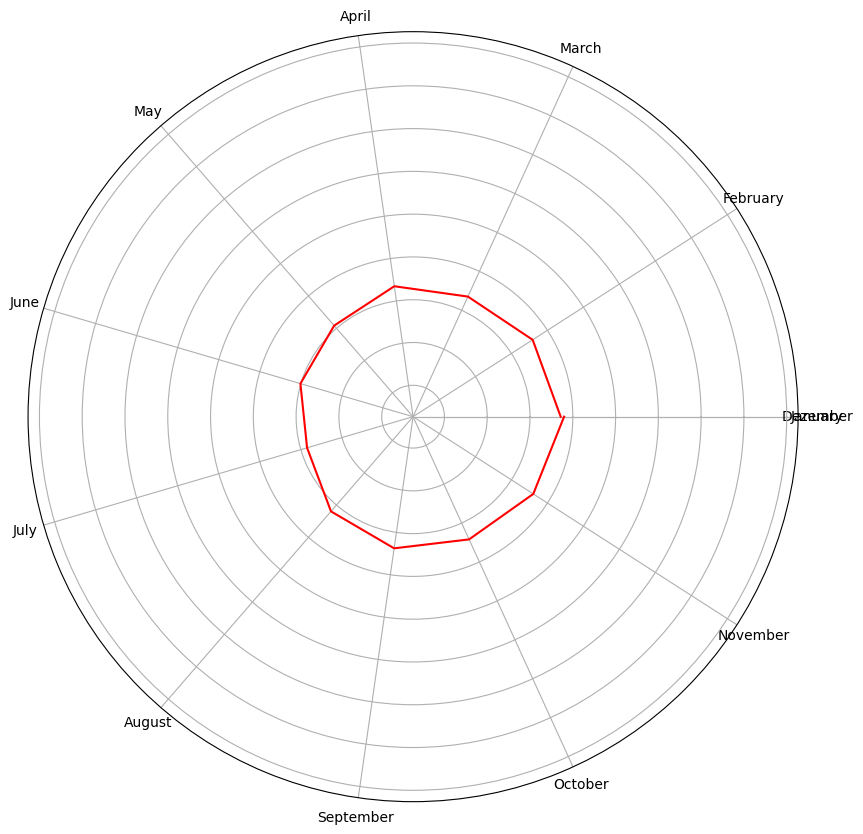

In [88]:
# Get data for CO
data_v2 = data[data["Parameter"] == "CO in mg/m3"][["Datum", "Parameter", "Wert"]].copy()

# Convert Datum to Year and Month
data_v2.loc[:, "Datum"] = pd.to_datetime(data_v2["Datum"].dt.year.astype(str) + "-" + data_v2["Datum"].dt.month.astype(str))

# Get mean value for each month
data_v2 = data_v2.groupby(["Datum", "Parameter"]).mean().reset_index()

# Map 'time_years' to a float
data_v2["time_years"] = data_v2["Datum"].dt.year + (data_v2["Datum"].dt.month - 1) / 12 

# Get Min and Max
r_min = data_v2["Wert"].min()
r_max = data_v2["Wert"].max()

# filter year 2000
data_v2 = data_v2[data_v2["time_years"].astype(int) == 2000]

# theta and r
theta = np.linspace(0, 2 * np.pi, 12)
r = data_v2["Wert"]

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.plot(theta, r + 1, color="red")
ax.set_rmin(r_min)
ax.set_rmax(r_max)

ax.axes.get_yaxis().set_ticklabels([])


ax.axes.get_xaxis().set_ticks(theta)
ax.axes.get_xaxis().set_ticklabels(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "Dezember"])


data_v2

In [ ]:


# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
ax.plot(theta, r, color="red", linewidth=2)
ax.fill(theta, r, color="red", alpha=0.2)

# set ticks as months
ax.set_xticks()